In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df_x_train = pd.read_csv('data/x_train_class.csv', index_col=0)
df_y_train = pd.read_csv('data/y_train_class.csv', index_col=0)

In [3]:
df_x_train.head()

,1,2,9,10,12,13,14,15,16,18,...,100628307,100630918,100631378,100642175,100652770,100652791,100653022,100689073,100689074,100820829
sw948,4.063884,3.594257,9.529689,6.740306,3.830637,3.751455,9.514933,3.385997,9.125257,6.499964,...,3.451310,5.681741,3.452094,5.541555,5.345914,3.306113,4.295348,3.260120,3.234298,6.773936
mkn45,3.795708,3.587633,7.474039,4.230111,4.136858,8.231481,9.248871,3.343609,10.242179,4.155514,...,3.517266,5.471486,3.456001,6.452955,4.510197,3.273790,4.282714,3.577665,3.363534,5.897890
j82,4.717745,3.816445,8.329890,4.542543,4.443213,3.834258,8.612918,3.683737,10.086658,5.139002,...,3.627550,5.375150,3.474723,4.517609,4.268056,3.476972,3.994838,3.683059,3.375735,5.427906
sknfi,4.338183,3.749382,8.297267,5.911274,3.915953,3.699066,8.846982,3.763437,9.328351,7.383348,...,3.945743,5.570602,3.541147,6.887191,4.065278,3.414457,3.906975,3.582676,3.187661,4.919210
te14,4.182824,3.627189,8.209574,3.672721,3.418317,5.969488,9.005162,3.404797,10.624380,4.212197,...,3.584055,4.442833,3.514525,4.820618,4.510451,3.118535,4.811349,3.593005,6.203332,5.143104


In [4]:
df_y_train.head()

,Beta
cell_line,
sw948,0.037500
mkn45,0.026786
j82,0.012500
sknfi,0.012500
te14,0.023214


In [5]:
full_df = pd.concat([df_x_train, df_y_train], axis=1)
full_df.head()

,1,2,9,10,12,13,14,15,16,18,...,100630918,100631378,100642175,100652770,100652791,100653022,100689073,100689074,100820829,Beta
cell_line,,,,,,,,,,,,,,,,,,,,,
sw948,4.063884,3.594257,9.529689,6.740306,3.830637,3.751455,9.514933,3.385997,9.125257,6.499964,...,5.681741,3.452094,5.541555,5.345914,3.306113,4.295348,3.260120,3.234298,6.773936,0.037500
mkn45,3.795708,3.587633,7.474039,4.230111,4.136858,8.231481,9.248871,3.343609,10.242179,4.155514,...,5.471486,3.456001,6.452955,4.510197,3.273790,4.282714,3.577665,3.363534,5.897890,0.026786
j82,4.717745,3.816445,8.329890,4.542543,4.443213,3.834258,8.612918,3.683737,10.086658,5.139002,...,5.375150,3.474723,4.517609,4.268056,3.476972,3.994838,3.683059,3.375735,5.427906,0.012500
sknfi,4.338183,3.749382,8.297267,5.911274,3.915953,3.699066,8.846982,3.763437,9.328351,7.383348,...,5.570602,3.541147,6.887191,4.065278,3.414457,3.906975,3.582676,3.187661,4.919210,0.012500
te14,4.182824,3.627189,8.209574,3.672721,3.418317,5.969488,9.005162,3.404797,10.624380,4.212197,...,4.442833,3.514525,4.820618,4.510451,3.118535,4.811349,3.593005,6.203332,5.143104,0.023214


<AxesSubplot:xlabel='Beta', ylabel='count'>

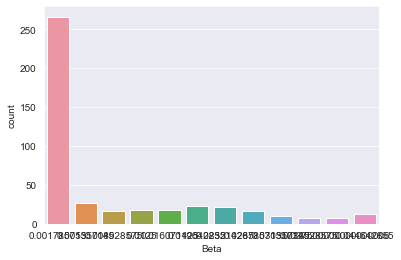

In [6]:
sns.countplot(x = 'Beta', data=full_df)

In [7]:
class2idx = {
    0.001785715:0,
    0.005357145:1,
    0.008928575:2,
    0.0125:3,
    0.016071425:4,
    0.019642855:5,
    0.023214285:6,
    0.026785715:7,
    0.030357145:8,
    0.033928575:9,
    0.0375:10,
    0.037500000000000006:10,
    0.041071425:11,
    0.044642855:12,
}

idx2class = {v: k for k, v in class2idx.items()}

full_df['Beta'].replace(class2idx, inplace=True)

In [8]:
full_df.to_csv('data/full_df.csv')

In [9]:
X = full_df.iloc[:, 0:-1]
y = full_df.iloc[:, -1]

In [10]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
        "class_2": 0,
        "class_3": 0,
        "class_4": 0,
        "class_5": 0,
        "class_6": 0,
        "class_7": 0,
        "class_8": 0,
        "class_9": 0,
        "class_10": 0,
        "class_11": 0,
        "class_12": 0,

    }

    for i in obj:
        if i == 0:
            count_dict['class_0'] += 1
        elif i == 1:
            count_dict['class_1'] += 1
        elif i == 2:
            count_dict['class_2'] += 1
        elif i == 3:
            count_dict['class_3'] += 1
        elif i == 4:
            count_dict['class_4'] += 1
        elif i == 5:
            count_dict['class_5'] += 1
        elif i == 6:
            count_dict['class_6'] += 1
        elif i == 7:
            count_dict['class_7'] += 1
        elif i==8:
            count_dict['class_8'] += 1
        elif i==9:
            count_dict['class_9'] += 1
        elif i==10:
            count_dict['class_10'] += 1
        elif i==11:
            count_dict['class_11'] += 1
        elif i==12:
            count_dict['class_12'] += 1
        else:
            print("Check classes.")
            print(i)

    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

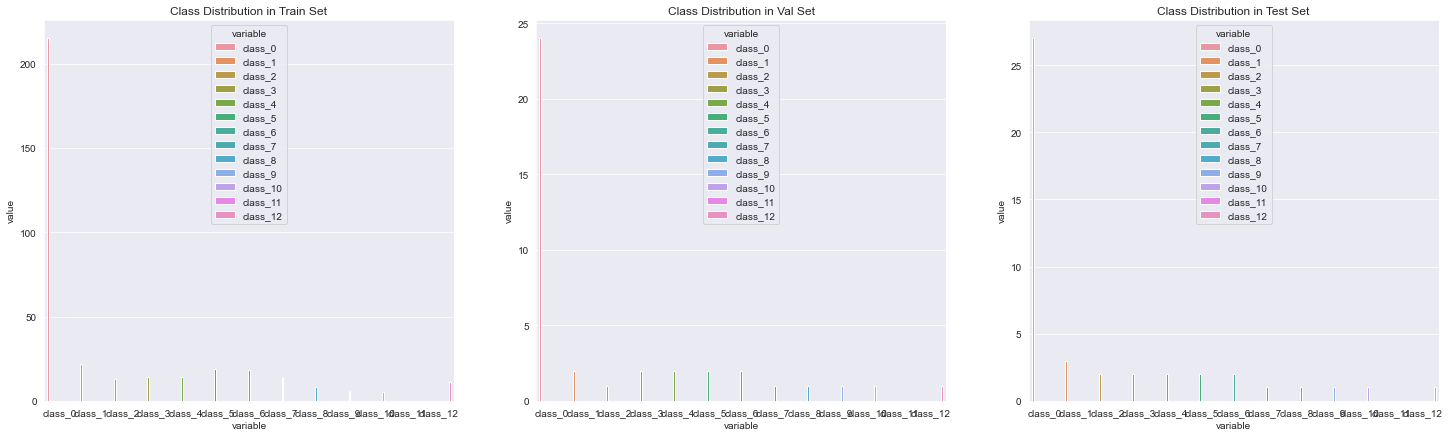

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [14]:
class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [15]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)

In [16]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)

tensor([0.0047, 0.0455, 0.0769, 0.0714, 0.0714, 0.0526, 0.0556, 0.0714, 0.1250,
        0.1667, 0.2000,    inf, 0.0909])


In [17]:
class_weights_all = class_weights[target_list]

In [18]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [19]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 13

In [20]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=18523, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [25]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [26]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()


    # VALIDATION
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()



    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.10366 | Val Loss: 2.68985 | Train Acc: 24.478| Val Acc: 0.000
Epoch 002: | Train Loss: 1.56521 | Val Loss: 2.81200 | Train Acc: 42.783| Val Acc: 0.000
Epoch 003: | Train Loss: 1.29856 | Val Loss: 2.94455 | Train Acc: 51.522| Val Acc: 2.500
Epoch 004: | Train Loss: 1.11102 | Val Loss: 3.03232 | Train Acc: 60.826| Val Acc: 7.500
Epoch 005: | Train Loss: 0.81606 | Val Loss: 3.05257 | Train Acc: 70.565| Val Acc: 0.000
Epoch 006: | Train Loss: 0.69333 | Val Loss: 3.07418 | Train Acc: 78.174| Val Acc: 5.000
Epoch 007: | Train Loss: 0.53620 | Val Loss: 3.20127 | Train Acc: 78.261| Val Acc: 7.500
Epoch 008: | Train Loss: 0.42874 | Val Loss: 3.15648 | Train Acc: 81.652| Val Acc: 2.500
Epoch 009: | Train Loss: 0.34803 | Val Loss: 3.06643 | Train Acc: 84.913| Val Acc: 5.000
Epoch 010: | Train Loss: 0.28179 | Val Loss: 3.07096 | Train Acc: 88.957| Val Acc: 5.000
Epoch 011: | Train Loss: 0.24185 | Val Loss: 3.11203 | Train Acc: 90.609| Val Acc: 5.000
Epoch 012: | Train Lo

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

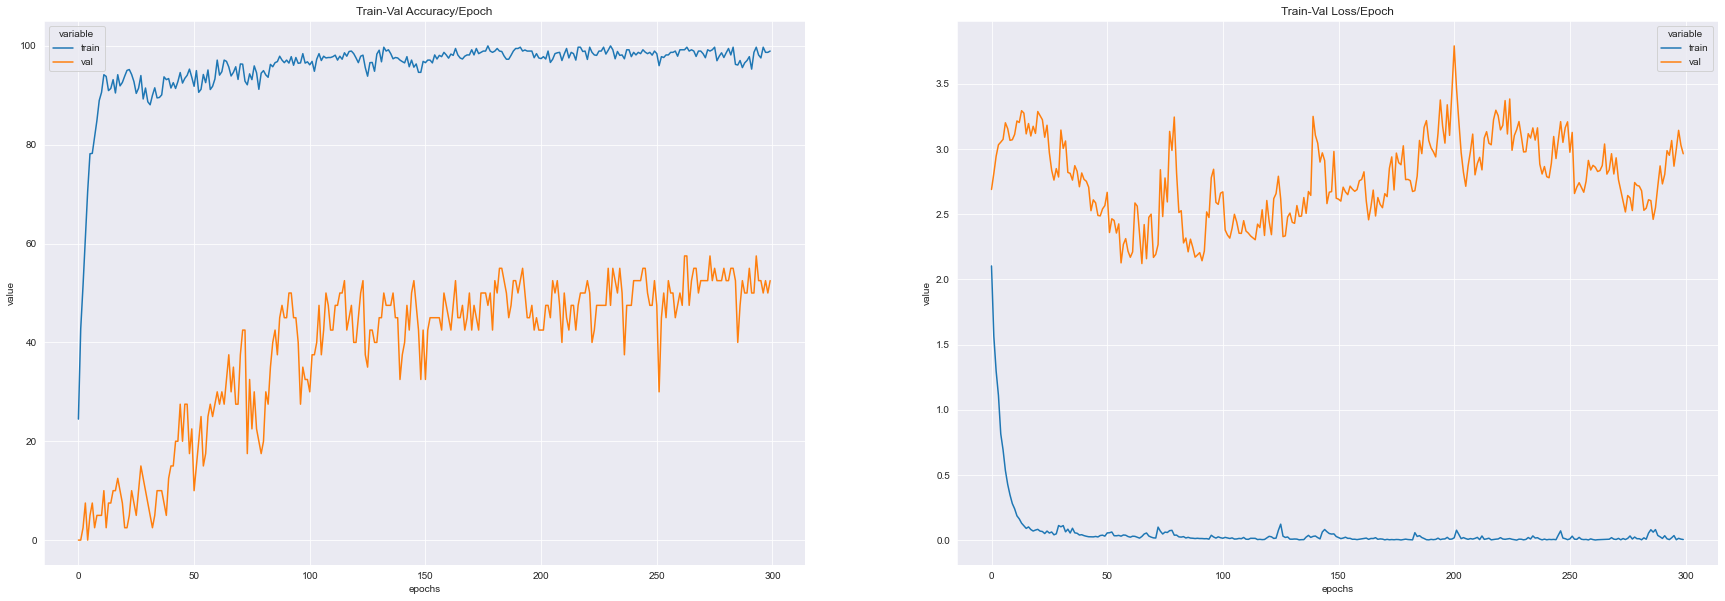

In [27]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [28]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [29]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [30]:
print(y_pred_list)

[0, 0, 0, 0, 12, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 12, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0]


<AxesSubplot:>

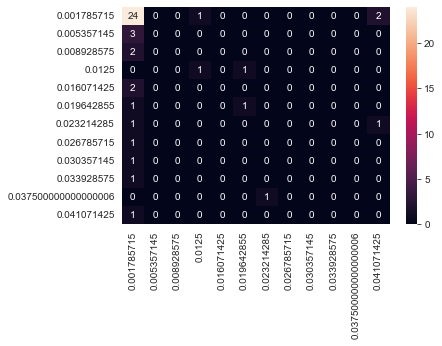

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [32]:
len(y_pred_list)

45

In [33]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.65      0.89      0.75        27
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         2
         3.0       0.50      0.50      0.50         2
         4.0       0.00      0.00      0.00         2
         5.0       0.50      0.50      0.50         2
         6.0       0.00      0.00      0.00         2
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1

    accuracy                           0.58        45
   macro avg       0.14      0.16      0.15        45
weighted avg       0.43      0.58      0.49        45



C:\Users\Udi\Documents\GitHub\RadiationProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Udi\Documents\GitHub\RadiationProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Udi\Documents\GitHub\RadiationProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier